In [1]:
from csv import DictReader

with open('octane_database.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    compounds = [r for r in reader]
csv_file.close()
print(len(compounds))

278


In [2]:
smiles = [c['canonical_smiles'] for c in compounds]
mon = [[float(c['properties.motor_octane_number.value'])] for c in compounds]
ron = [[float(c['properties.research_octane_number.value'])] for c in compounds]
os = [[ron[i][0] - mon[i][0]] for i in range(len(compounds))]

In [3]:
from sklearn.model_selection import train_test_split

mon_smiles_train, mon_smiles_test, mon_train, mon_test = train_test_split(smiles, mon, test_size=0.1, random_state=42)
ron_smiles_train, ron_smiles_test, ron_train, ron_test = train_test_split(smiles, ron, test_size=0.1, random_state=42)
os_smiles_train, os_smiles_test, os_train, os_test = train_test_split(smiles, os, test_size=0.1, random_state=42)

In [4]:
from ecnet.datasets import QSPRDataset

dataset_mon_train = QSPRDataset(mon_smiles_train, mon_train, backend='alvadesc')
dataset_mon_test = QSPRDataset(mon_smiles_test, mon_test, backend='alvadesc')
dataset_ron_train = QSPRDataset(ron_smiles_train, ron_train, backend='alvadesc')
dataset_ron_test = QSPRDataset(ron_smiles_test, ron_test, backend='alvadesc')
dataset_os_train = QSPRDataset(os_smiles_train, os_train, backend='alvadesc')
dataset_os_test = QSPRDataset(os_smiles_test, os_test, backend='alvadesc')

In [5]:
from ecnet.tasks import select_rfr

desc_idx_mon, _ = select_rfr(dataset_mon_train, total_importance=0.9999, n_estimators=50, n_jobs=4)
desc_idx_mon = desc_idx_mon[:250]

desc_idx_ron, _ = select_rfr(dataset_ron_train, total_importance=0.9999, n_estimators=50, n_jobs=4)
desc_idx_ron = desc_idx_ron[:250]

desc_idx_os, _ = select_rfr(dataset_os_train, total_importance=0.9999, n_estimators=50, n_jobs=4)
desc_idx_os = desc_idx_os[:250]

In [6]:
dataset_mon_train.set_desc_index(desc_idx_mon)
dataset_mon_test.set_desc_index(desc_idx_mon)
dataset_ron_train.set_desc_index(desc_idx_ron)
dataset_ron_test.set_desc_index(desc_idx_ron)
dataset_os_train.set_desc_index(desc_idx_os)
dataset_os_test.set_desc_index(desc_idx_os)

In [7]:
desc_idx_mon = [str(d) for d in desc_idx_mon]
desc_idx_ron = [str(d) for d in desc_idx_ron]
desc_idx_os = [str(d) for d in desc_idx_os]

with open('desc_idx_mon.txt', 'w') as txt_file:
    txt_file.writelines(desc_idx_mon)
txt_file.close()
with open('desc_idx_ron.txt', 'w') as txt_file:
    txt_file.writelines(desc_idx_ron)
txt_file.close()
with open('desc_idx_os.txt', 'w') as txt_file:
    txt_file.writelines(desc_idx_os)
txt_file.close()

In [8]:
from ecnet import ECNet

model_mon = ECNet(dataset_mon_train.desc_vals.shape[1], dataset_mon_train.target_vals.shape[1], 128, 2)
model_ron = ECNet(dataset_ron_train.desc_vals.shape[1], dataset_ron_train.target_vals.shape[1], 128, 2)
model_os = ECNet(dataset_os_train.desc_vals.shape[1], dataset_os_train.target_vals.shape[1], 128, 2)

In [9]:
train_loss_mon, valid_loss_mon = model_mon.fit(
    dataset=dataset_mon_train, valid_size=0.112, verbose=5,
    patience=32, epochs=512, random_state=24, lr=0.001
)
train_loss_mon = train_loss_mon[1:]
valid_loss_mon = valid_loss_mon[1:]

Epoch: 0 | Train loss: 4883.268541490709 | Valid loss: 9223372036854775807
Epoch: 5 | Train loss: 306.20011420722483 | Valid loss: 443.7887878417969
Epoch: 10 | Train loss: 206.23985620447107 | Valid loss: 300.55029296875
Epoch: 15 | Train loss: 202.59743905282235 | Valid loss: 284.0702209472656
Epoch: 20 | Train loss: 159.18382799303208 | Valid loss: 222.44467163085938
Epoch: 25 | Train loss: 146.06350336848078 | Valid loss: 211.44973754882812
Epoch: 30 | Train loss: 138.57658606176977 | Valid loss: 198.73623657226562
Epoch: 35 | Train loss: 138.16488936140732 | Valid loss: 190.3385467529297
Epoch: 40 | Train loss: 124.61044820149739 | Valid loss: 188.62753295898438
Epoch: 45 | Train loss: 121.86316756514816 | Valid loss: 201.57286071777344
Epoch: 50 | Train loss: 137.8927826752534 | Valid loss: 201.1947021484375
Epoch: 55 | Train loss: 118.273758828103 | Valid loss: 190.42678833007812
Epoch: 60 | Train loss: 117.06006532961185 | Valid loss: 204.3322296142578
Epoch: 65 | Train loss: 1

In [10]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

mon_target_vals = [t[0] for t in dataset_mon_train.target_vals]
mon_learn_exp, mon_valid_exp = train_test_split(mon_target_vals, test_size=0.112, random_state=24)
mon_train_pred = model_mon(dataset_mon_train.desc_vals).detach().numpy()
mon_train_pred = [t[0] for t in mon_train_pred]
mon_learn_pred, mon_valid_pred = train_test_split(mon_train_pred, test_size=0.112, random_state=24)

mon_test_exp = [t[0] for t in dataset_mon_test.target_vals]
mon_test_pred = model_mon(dataset_mon_test.desc_vals).detach().numpy()
mon_test_pred = [t[0] for t in mon_test_pred]

learn_rmse = mean_squared_error(mon_learn_exp, mon_learn_pred, squared=False)
valid_rmse = mean_squared_error(mon_valid_exp, mon_valid_pred, squared=False)
test_rmse = mean_squared_error(mon_test_exp, mon_test_pred, squared=False)

learn_r2 = r2_score(mon_learn_exp, mon_learn_pred)
valid_r2 = r2_score(mon_valid_exp, mon_valid_pred)
test_r2 = r2_score(mon_test_exp, mon_test_pred)

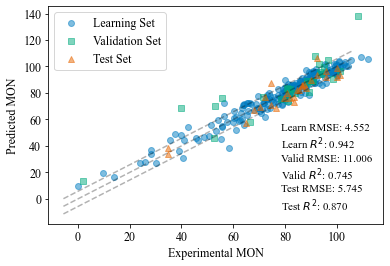

In [11]:
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText

min_val = min(min(mon_learn_pred), min(mon_learn_exp)) - 0.05 * max(max(mon_learn_pred), max(mon_learn_exp))
max_val = max(max(mon_learn_pred), max(mon_learn_exp)) - 0.05 * max(max(mon_learn_pred), max(mon_learn_exp))
plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size': 12})
plt.xlabel('Experimental MON')
plt.ylabel('Predicted MON')
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val + test_rmse, max_val + test_rmse], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val - test_rmse, max_val - test_rmse], 'k--', alpha=0.3)
plt.scatter(mon_learn_exp, mon_learn_pred, color=(0, 114/235, 178/235), label='Learning Set', marker='o', alpha=0.5)
plt.scatter(mon_valid_exp, mon_valid_pred, color=(0, 158/235, 115/235), label='Validation Set', marker='s', alpha=0.5)
plt.scatter(mon_test_exp, mon_test_pred, color=(213/235, 94/235, 0), label='Test Set', marker='^', alpha=0.5)
plt.legend(loc='upper left')
string = 'Learn RMSE: {:.3f}'.format(learn_rmse) + '\n'
string += 'Learn $R^2$: {:.3f}'.format(learn_r2) + '\n'
string += 'Valid RMSE: {:.3f}'.format(valid_rmse) + '\n'
string += 'Valid $R^2$: {:.3f}'.format(valid_r2) + '\n'
string += 'Test RMSE: {:.3f}'.format(test_rmse) + '\n'
string += 'Test $R^2$: {:.3f}'.format(test_r2)
plt.rcParams.update({'font.size': 11})
text_box = AnchoredText(string, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', edgecolor='w')
plt.gca().add_artist(text_box)
plt.show()

In [21]:
train_loss_ron, valid_loss_ron = model_ron.fit(
    dataset=dataset_ron_train, valid_size=0.112, verbose=5,
    patience=32, epochs=512, random_state=24, lr=0.001
)
train_loss_ron = train_loss_ron[1:]
valid_loss_ron = valid_loss_ron[1:]

Epoch: 0 | Train loss: 134.3065058733966 | Valid loss: 9223372036854775807
Epoch: 5 | Train loss: 68.0088535686871 | Valid loss: 176.82847595214844
Epoch: 10 | Train loss: 87.41530616004188 | Valid loss: 172.9115447998047
Epoch: 15 | Train loss: 62.536090404063735 | Valid loss: 182.63059997558594
Epoch: 20 | Train loss: 55.864035391592765 | Valid loss: 142.31466674804688
Epoch: 25 | Train loss: 56.42689156747079 | Valid loss: 144.10220336914062
Epoch: 30 | Train loss: 48.57359791661168 | Valid loss: 144.60646057128906
Epoch: 35 | Train loss: 50.89886313086158 | Valid loss: 116.00077056884766
Epoch: 40 | Train loss: 48.949882627607465 | Valid loss: 125.17750549316406
Epoch: 45 | Train loss: 48.15757095061981 | Valid loss: 125.53544616699219
Epoch: 50 | Train loss: 44.2374903704669 | Valid loss: 139.63841247558594
Epoch: 55 | Train loss: 37.74383276862067 | Valid loss: 142.12998962402344
Epoch: 60 | Train loss: 33.01679112889745 | Valid loss: 110.0998306274414
Epoch: 65 | Train loss: 31.

In [22]:
ron_target_vals = [t[0] for t in dataset_ron_train.target_vals]
ron_learn_exp, ron_valid_exp = train_test_split(ron_target_vals, test_size=0.112, random_state=24)
ron_train_pred = model_ron(dataset_ron_train.desc_vals).detach().numpy()
ron_train_pred = [t[0] for t in ron_train_pred]
ron_learn_pred, ron_valid_pred = train_test_split(ron_train_pred, test_size=0.112, random_state=24)

ron_test_exp = [t[0] for t in dataset_ron_test.target_vals]
ron_test_pred = model_ron(dataset_ron_test.desc_vals).detach().numpy()
ron_test_pred = [t[0] for t in ron_test_pred]

learn_rmse = mean_squared_error(ron_learn_exp, ron_learn_pred, squared=False)
valid_rmse = mean_squared_error(ron_valid_exp, ron_valid_pred, squared=False)
test_rmse = mean_squared_error(ron_test_exp, ron_test_pred, squared=False)

learn_r2 = r2_score(ron_learn_exp, ron_learn_pred)
valid_r2 = r2_score(ron_valid_exp, ron_valid_pred)
test_r2 = r2_score(ron_test_exp, ron_test_pred)

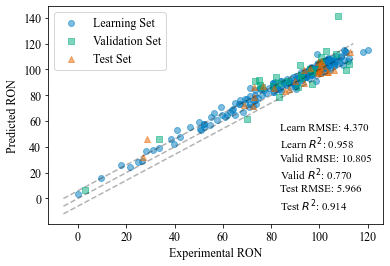

In [23]:
min_val = min(min(ron_learn_pred), min(ron_learn_exp)) - 0.05 * max(max(ron_learn_pred), max(ron_learn_exp))
max_val = max(max(ron_learn_pred), max(ron_learn_exp)) - 0.05 * max(max(ron_learn_pred), max(ron_learn_exp))
plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size': 12})
plt.xlabel('Experimental RON')
plt.ylabel('Predicted RON')
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val + test_rmse, max_val + test_rmse], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val - test_rmse, max_val - test_rmse], 'k--', alpha=0.3)
plt.scatter(ron_learn_exp, ron_learn_pred, color=(0, 114/235, 178/235), label='Learning Set', marker='o', alpha=0.5)
plt.scatter(ron_valid_exp, ron_valid_pred, color=(0, 158/235, 115/235), label='Validation Set', marker='s', alpha=0.5)
plt.scatter(ron_test_exp, ron_test_pred, color=(213/235, 94/235, 0), label='Test Set', marker='^', alpha=0.5)
plt.legend(loc='upper left')
string = 'Learn RMSE: {:.3f}'.format(learn_rmse) + '\n'
string += 'Learn $R^2$: {:.3f}'.format(learn_r2) + '\n'
string += 'Valid RMSE: {:.3f}'.format(valid_rmse) + '\n'
string += 'Valid $R^2$: {:.3f}'.format(valid_r2) + '\n'
string += 'Test RMSE: {:.3f}'.format(test_rmse) + '\n'
string += 'Test $R^2$: {:.3f}'.format(test_r2)
plt.rcParams.update({'font.size': 11})
text_box = AnchoredText(string, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', edgecolor='w')
plt.gca().add_artist(text_box)
plt.show()

In [15]:
train_loss_os, valid_loss_os = model_os.fit(
    dataset=dataset_os_train, valid_size=0.112, verbose=5,
    patience=32, epochs=512, random_state=24, lr=0.001
)
train_loss_os = train_loss_os[1:]
valid_loss_os = valid_loss_os[1:]

Epoch: 0 | Train loss: 124.16703810133376 | Valid loss: 9223372036854775807
Epoch: 5 | Train loss: 59.570424535253025 | Valid loss: 92.86493682861328
Epoch: 10 | Train loss: 36.01306769224974 | Valid loss: 54.41214370727539
Epoch: 15 | Train loss: 27.844459877357828 | Valid loss: 39.643497467041016
Epoch: 20 | Train loss: 23.65321112967826 | Valid loss: 35.228973388671875
Epoch: 25 | Train loss: 25.709256541621578 | Valid loss: 40.416542053222656
Epoch: 30 | Train loss: 18.541703610806852 | Valid loss: 29.615341186523438
Epoch: 35 | Train loss: 16.771394317214554 | Valid loss: 28.52857780456543
Epoch: 40 | Train loss: 14.887873881572002 | Valid loss: 33.964107513427734
Epoch: 45 | Train loss: 13.105660936853907 | Valid loss: 31.373210906982422
Epoch: 50 | Train loss: 11.481910782891351 | Valid loss: 31.775033950805664
Epoch: 55 | Train loss: 12.729684829711914 | Valid loss: 34.3215446472168
Epoch: 60 | Train loss: 12.137837994206059 | Valid loss: 35.12996292114258
Epoch: 65 | Train los

In [16]:
os_target_vals = [t[0] for t in dataset_os_train.target_vals]
os_learn_exp, os_valid_exp = train_test_split(os_target_vals, test_size=0.112, random_state=24)
os_train_pred = model_os(dataset_os_train.desc_vals).detach().numpy()
os_train_pred = [t[0] for t in os_train_pred]
os_learn_pred, os_valid_pred = train_test_split(os_train_pred, test_size=0.112, random_state=24)

os_test_exp = [t[0] for t in dataset_os_test.target_vals]
os_test_pred = model_os(dataset_os_test.desc_vals).detach().numpy()
os_test_pred = [t[0] for t in os_test_pred]

learn_rmse = mean_squared_error(os_learn_exp, os_learn_pred, squared=False)
valid_rmse = mean_squared_error(os_valid_exp, os_valid_pred, squared=False)
test_rmse = mean_squared_error(os_test_exp, os_test_pred, squared=False)

learn_r2 = r2_score(os_learn_exp, os_learn_pred)
valid_r2 = r2_score(os_valid_exp, os_valid_pred)
test_r2 = r2_score(os_test_exp, os_test_pred)

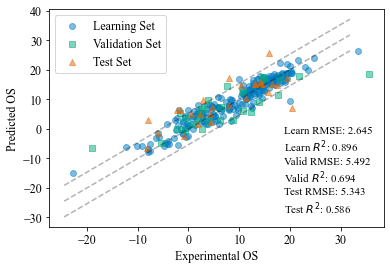

In [17]:
plt.clf()
min_val = min(min(os_learn_pred), min(os_learn_exp)) - 0.05 * max(max(os_learn_pred), max(os_learn_exp))
max_val = max(max(os_learn_pred), max(os_learn_exp)) - 0.05 * max(max(os_learn_pred), max(os_learn_exp))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size': 12})
plt.xlabel('Experimental OS')
plt.ylabel('Predicted OS')
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val + test_rmse, max_val + test_rmse], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val - test_rmse, max_val - test_rmse], 'k--', alpha=0.3)
plt.scatter(os_learn_exp, os_learn_pred, color=(0, 114/235, 178/235), label='Learning Set', marker='o', alpha=0.5)
plt.scatter(os_valid_exp, os_valid_pred, color=(0, 158/235, 115/235), label='Validation Set', marker='s', alpha=0.5)
plt.scatter(os_test_exp, os_test_pred, color=(213/235, 94/235, 0), label='Test Set', marker='^', alpha=0.5)
plt.legend(loc='upper left')
string = 'Learn RMSE: {:.3f}'.format(learn_rmse) + '\n'
string += 'Learn $R^2$: {:.3f}'.format(learn_r2) + '\n'
string += 'Valid RMSE: {:.3f}'.format(valid_rmse) + '\n'
string += 'Valid $R^2$: {:.3f}'.format(valid_r2) + '\n'
string += 'Test RMSE: {:.3f}'.format(test_rmse) + '\n'
string += 'Test $R^2$: {:.3f}'.format(test_r2)
plt.rcParams.update({'font.size': 11})
text_box = AnchoredText(string, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', edgecolor='w')
plt.gca().add_artist(text_box)
plt.show()

In [24]:
dos_learn_exp = [ron_learn_exp[i] - mon_learn_pred[i] for i in range(len(ron_learn_exp))]
dos_valid_exp = [ron_valid_exp[i] - mon_valid_pred[i] for i in range(len(ron_valid_exp))]
dos_test_exp = [ron_test_exp[i] - mon_test_pred[i] for i in range(len(ron_test_exp))]

dos_learn_pred = [ron_learn_pred[i] - mon_learn_pred[i] for i in range(len(ron_learn_pred))]
dos_valid_pred = [ron_valid_pred[i] - mon_valid_pred[i] for i in range(len(ron_valid_pred))]
dos_test_pred = [ron_test_pred[i] - mon_test_pred[i] for i in range(len(ron_test_pred))]

learn_rmse = mean_squared_error(dos_learn_exp, dos_learn_pred, squared=False)
valid_rmse = mean_squared_error(dos_valid_exp, dos_valid_pred, squared=False)
test_rmse = mean_squared_error(dos_test_exp, dos_test_pred, squared=False)

learn_r2 = r2_score(dos_learn_exp, dos_learn_pred)
valid_r2 = r2_score(dos_valid_exp, dos_valid_pred)
test_r2 = r2_score(dos_test_exp, dos_test_pred)

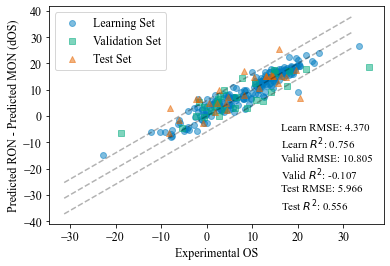

In [25]:
plt.clf()
min_val = min(min(dos_learn_pred), min(dos_learn_exp)) - 0.05 * max(max(dos_learn_pred), max(dos_learn_exp))
max_val = max(max(dos_learn_pred), max(dos_learn_exp)) - 0.05 * max(max(dos_learn_pred), max(dos_learn_exp))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size': 12})
plt.xlabel('Experimental OS')
plt.ylabel('Predicted RON - Predicted MON (dOS)')
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val + test_rmse, max_val + test_rmse], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val - test_rmse, max_val - test_rmse], 'k--', alpha=0.3)
plt.scatter(os_learn_exp, os_learn_pred, color=(0, 114/235, 178/235), label='Learning Set', marker='o', alpha=0.5)
plt.scatter(os_valid_exp, os_valid_pred, color=(0, 158/235, 115/235), label='Validation Set', marker='s', alpha=0.5)
plt.scatter(os_test_exp, os_test_pred, color=(213/235, 94/235, 0), label='Test Set', marker='^', alpha=0.5)
plt.legend(loc='upper left')
string = 'Learn RMSE: {:.3f}'.format(learn_rmse) + '\n'
string += 'Learn $R^2$: {:.3f}'.format(learn_r2) + '\n'
string += 'Valid RMSE: {:.3f}'.format(valid_rmse) + '\n'
string += 'Valid $R^2$: {:.3f}'.format(valid_r2) + '\n'
string += 'Test RMSE: {:.3f}'.format(test_rmse) + '\n'
string += 'Test $R^2$: {:.3f}'.format(test_r2)
plt.rcParams.update({'font.size': 11})
text_box = AnchoredText(string, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', edgecolor='w')
plt.gca().add_artist(text_box)
plt.show()

In [20]:
model_mon.save('model_mon.pt')
model_ron.save('model_ron.pt')
model_os.save('model_os.pt')